# Time Series - Forecasting with Prophet


To install Prophet use *pip install fbprophet* in command line or with Anaconda *conda install -c conda-forge fbprophet*

In [1]:
import datetime as dt
import math

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fbprophet import Prophet

%matplotlib inline
plt.rcParams["font.size"] = 14
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Importing plotly failed. Interactive plots will not work.


## Why bother?

<img src='images/prophet-fb-eg.png' width=800px>

Now we introduce a time series forecasting model designed to handle the common features of business time series seen above:
- Seasonal cycles
- Trend changes
- Outliers

Importantly, it is also designed to have intuitive parameters that can be adjusted without knowing the details of the underlying model.
This implementation is available as open source software in Python called **Prophet**.

## Introduction to Prophet

<a href="https://facebookincubator.github.io/prophet/">
<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/tumblr_inline_omh3tnv5zk1r1x9ql_500.png' align='right' style="width:300px"></a> 

* Open source software
* Released by Facebook’s Core Data Science team (Feb 23, 2017 in [github](https://github.com/facebookincubator/prophet))
* Used highly for forecasting time series data - especially in business applications
* Effective with missing data, outliers and dramatic changes
* Allows the implementation of events/holidays
* Python implementation
* ( - ) it is a little bit of a black box

[Read the article](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf)

## How Prophet works

Prophet uses an additive regression model with the following main components:

* Piecewise linear / logistic growth curve trend
* Automatically detects changes in trends by selecting change points
* A *yearly* seasonal component (using Fourier series)
* A *weekly* seasonal component (using dummy variables)
* User provided list of important holidays *(optional)*

### Things to keep in mind with Prophet

Prophet expects daily data by default - remember to specify if you have a different format.

If Prophet does not detect a certain type of seasonality - it turns it off. So if you know this type should actually be there - you need to specify.


## Prophet with Schiphol Data

In [10]:
schiphol = pd.read_csv('data/schiphol_passengers.csv', index_col='date', parse_dates=True)
schiphol.index.freq = 'MS'
schiphol = (schiphol
            .rename(columns={'total_passengers': 'y'})
            .assign(y = lambda df: df['y']/1000000,  #the variable of interest should be called 'y' for Prophet
                   ds = lambda df: df.index)  #Prophet needs a 'ds' column with timestamps
           )

schiphol_train = schiphol.loc[:'2017 Jan']
schiphol_test = schiphol.loc['2017 Jan':]
schiphol.head()

,y,ds
date,,
1999-01-01,2.372578,1999-01-01
1999-02-01,2.332664,1999-02-01
1999-03-01,2.825328,1999-03-01
1999-04-01,2.901478,1999-04-01
1999-05-01,3.263955,1999-05-01


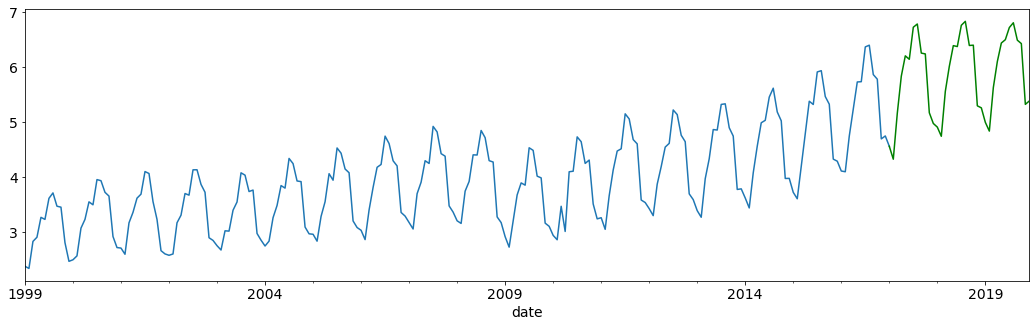

In [11]:
fig, ax = plt.subplots(figsize=(18,5))
schiphol_train['y'].plot(ax=ax);
schiphol_test['y'].plot(ax=ax, c='g');

In [12]:
model = Prophet()

# explicitly set seasonality:
model = Prophet(daily_seasonality=False, 
                weekly_seasonality=False, 
                yearly_seasonality=True)

model.fit(schiphol_train);

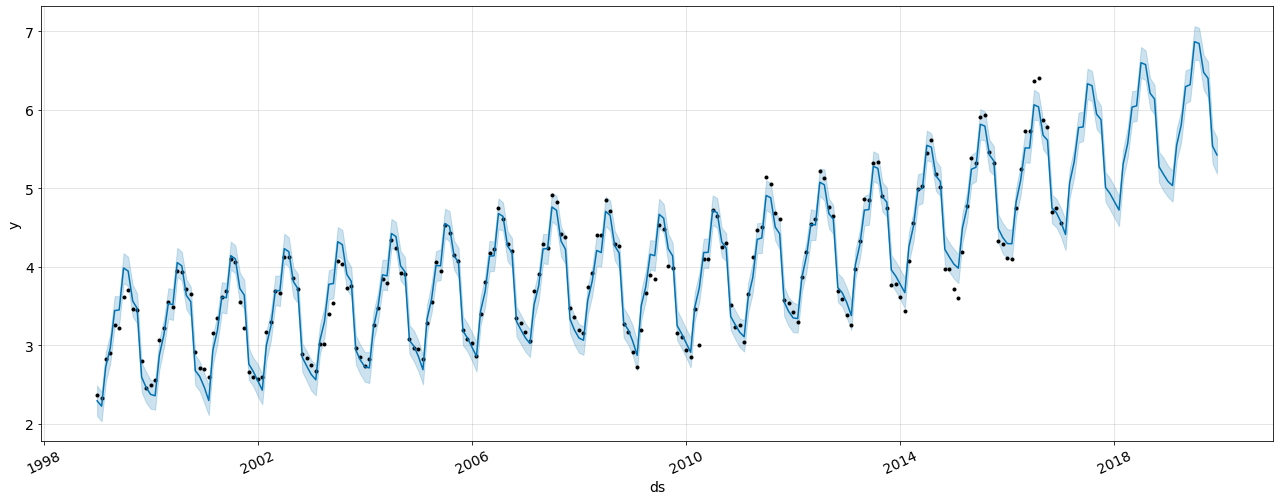

In [13]:
future = model.make_future_dataframe(periods=35, freq='MS') 
forecast = model.predict(future)

model.plot(forecast, figsize=(18,7));
plt.xticks(rotation=25);

Prophet has its own plotting functionality compatible with Matplotlib. It has some customization restrictions though.
Black dots indicate the real data points. Dark blue line shows the model fit with light blue area indicating lower to upper prediction bounds.

Let's have a closer look at the prediction area and compare it to the actual  test set values:

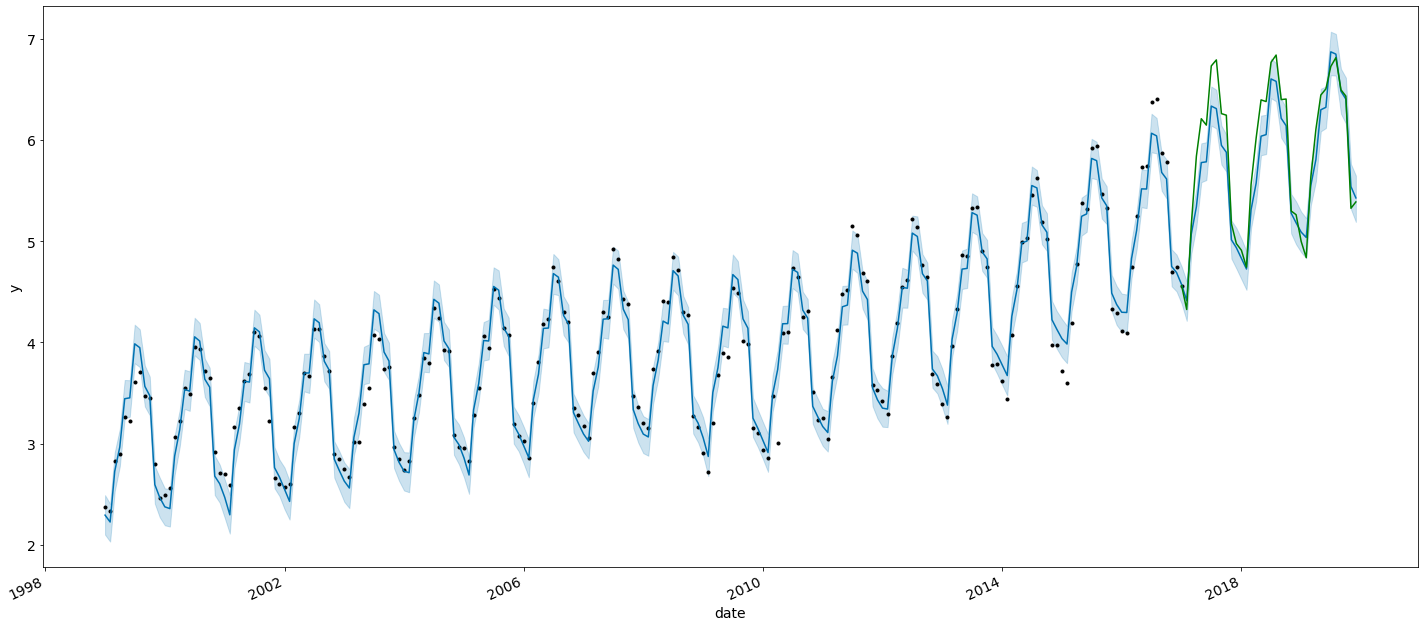

In [14]:
fig, ax = plt.subplots()
model.plot(forecast, ax=ax);
schiphol_test['y'].plot(ax=ax, c='green')
plt.xticks(rotation=25)
# plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2019-12-01'))
plt.show()

Predictions look good, especially for fall and winter months; there is some underestimation for the summer peaks.

Before we use some metrics to evaluate the model's predictive power, let's see what the Prophet's output actually looks like:

In [15]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1999-01-01,3.089729,2.100901,2.491318,3.089729,3.089729,-0.795696,-0.795696,-0.795696,-0.795696,-0.795696,-0.795696,0.0,0.0,0.0,2.294033
1,1999-02-01,3.096853,2.032331,2.405365,3.096853,3.096853,-0.871017,-0.871017,-0.871017,-0.871017,-0.871017,-0.871017,0.0,0.0,0.0,2.225836
2,1999-03-01,3.103287,2.529726,2.913826,3.103287,3.103287,-0.377347,-0.377347,-0.377347,-0.377347,-0.377347,-0.377347,0.0,0.0,0.0,2.725940
3,1999-04-01,3.110411,2.774416,3.143645,3.110411,3.110411,-0.143654,-0.143654,-0.143654,-0.143654,-0.143654,-0.143654,0.0,0.0,0.0,2.966757
4,1999-05-01,3.117305,3.249545,3.628231,3.117305,3.117305,0.325885,0.325885,0.325885,0.325885,0.325885,0.325885,0.0,0.0,0.0,3.443190


If we want a more customized plot, we can get the necessary columns from the *forecast* dataframe and plot them as we usually would do with Pandas:

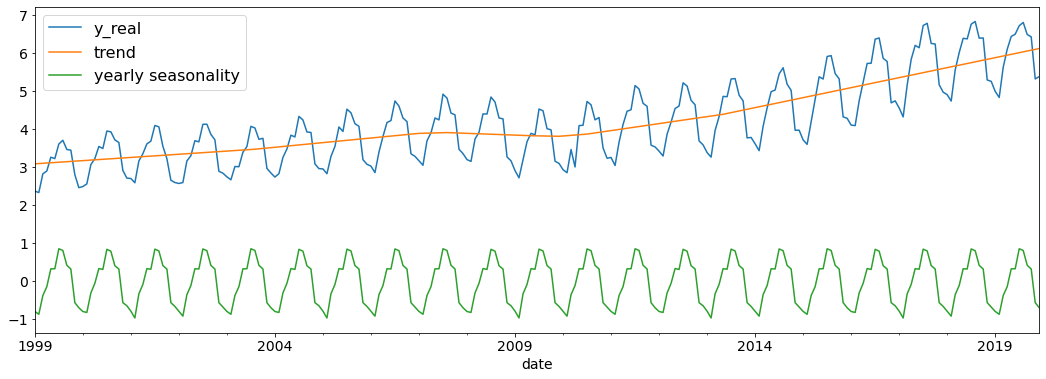

In [21]:
pltr = (forecast
         .set_index(schiphol.index)
        )

fig, ax = plt.subplots(figsize=(18,6))
schiphol['y'].plot(ax=ax);
pltr[['trend','yearly']].plot(ax=ax);
ax.legend(["y_real", "trend", "yearly seasonality"], prop={'size': 16});

We can also plot components of Prophet's forecast using `model.plot_components(forecast)`. Note how this also includes confidence boundaries for the future trend:

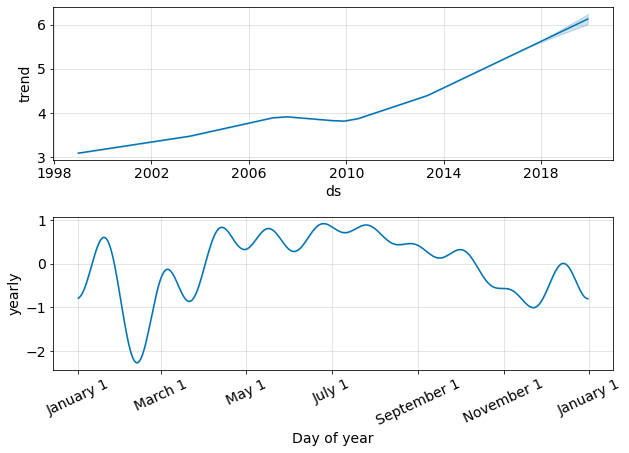

In [17]:
model.plot_components(forecast)
plt.xticks(rotation=25);

## Detecting Outliers

Identify and highlight on the plot the *training set* points that lie outside of the confidence boundaries of our Prophet model

*TIP:* Create a new variable that takes the real *y values* when it is an outlier and a missing value (np.nan) otherwise. Then plot it alongside Prophet's plot. Make sure the index of the new dataframe is the timestamps.

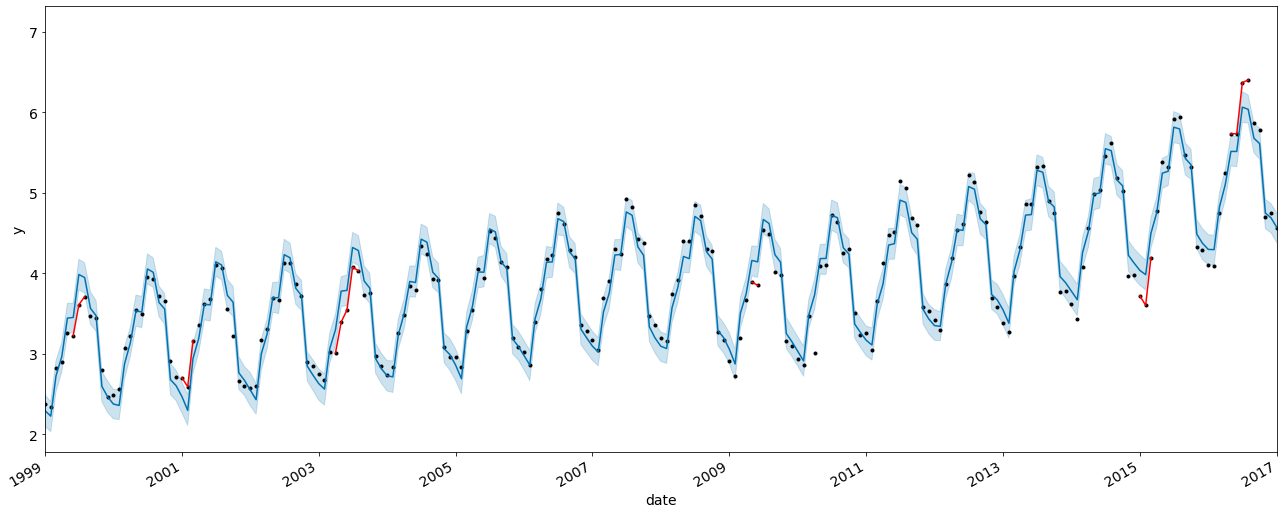

In [20]:
# %load answers/prophet_outliers.py
outliers = (forecast
            .set_index(schiphol.index)
            .assign(y_real=schiphol_train['y'],
                    outlier = lambda df:
                                    df.apply(
                                        lambda row :
                                                     np.nan if (row['yhat_lower'] <= row['y_real'] <= row['yhat_upper']) 
                                                     else row['y_real'], axis = 1))
        )

fig, ax = plt.subplots(figsize=(18,8))
model.plot(forecast, ax=ax);
outliers['outlier'].plot(ax=ax, c='red')
plt.xlim(pd.Timestamp('1999-01-01'), pd.Timestamp('2017-01-01'));

What do you think the outliers from 2003 are caused by?